In [21]:
import sys
all_paths = list(sys.path)
for p in all_paths:
    if "2.7" in p:
        sys.path.remove(p)
sys.path.append("../python/")
import uproot
import hist
import numpy as np
from hist.intervals import ratio_uncertainty
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.special import erf
from scipy.optimize import curve_fit
import re
from copy import deepcopy
from trigger_efficiency_plots import get_eff_hists
import correctionlib.schemav2 as cs
import rich
from hashlib import sha512

hep.style.use("CMS")


In [22]:
histdir = "/nfs/dust/cms/user/albrechs/UHH2/JetMassOutput/ttbarTrees/ForTriggerEff"
histdir = "trigger_hists/"
def plot_scalefactor(year, ref_trig, probe_trig, **kwargs):
    h_data = uproot.open(f"{histdir}/Data_{year}.root")
    h_mc = uproot.open(f"{histdir}/QCD_{year}.root")
    f,ax = plt.subplots(figsize=(11, 11))

    icolor = 0
    varname = "AK8_PT"
    xlabel="$p_{T,AK8}$"
    prescale_str = ""
    # lookup_str = "_lookup"
    lookup_str = ""
    rebin_factor=kwargs.get("rebin", 5)

    def fit_func(z,a=0.5,b=0.5,c=400,d=0.1):
        return a*(b+0.5*(1-b)*(1+erf((z-c)/d)))
    def fit_erf(x_,y_, fit_range=(None, None)):
        x = deepcopy(x_)
        y=deepcopy(y_)
        p0 = (1., 0., 500.,100.)
        if fit_range[0] is not None:
            y=y[x>=fit_range[0]]
            x = x[x>=fit_range[0]]
        if fit_range[1] is not None:
            y=y[x<fit_range[1]]
            x = x[x<fit_range[1]]
        popt, pcov = curve_fit(fit_func, x, y, maxfev=8000, p0=p0)#, bounds=([0.99,0,300,0],[1,0.04,900,200]))
        
        return popt, pcov
    pt_thr_match = re.search( r"[0-9]{3}",probe_trig)
    pt_thr = 550 if not pt_thr_match else int(pt_thr_match.group())
    x_min=kwargs.get("xmin", pt_thr-100)
    x_max=kwargs.get("xmax", pt_thr+150)
    variations=["nominal", "up", "down"]
    eff_data = {var:get_eff_hists(h_data, varname, ref_trig, probe_trig, rebin_factor=rebin_factor, lookup_str=lookup_str, prescale_str=prescale_str, variation=var) for var in variations}
    eff_mc = {var:get_eff_hists(h_mc, varname, ref_trig, probe_trig, rebin_factor=rebin_factor, lookup_str=lookup_str, prescale_str=prescale_str, variation=var) for var in variations}
    eff_fits = {k:{} for k in variations}
    sf_curves = {}
    fit_parameter={}
    x_plot = np.linspace(x_min,x_max,1000)
    fit_range_data = kwargs.get("fitrange_data",kwargs.get("fitrange",(0,1000)))
    fit_range_mc = kwargs.get("fitrange_mc",kwargs.get("fitrange",(0,1000)))
    
    for var in variations:
        alpha = 1.0 if var == "nominal" else 0.2

        ax.errorbar(eff_data[var][0].axes[0].centers,eff_data[var][2], yerr=eff_data[var][3], label=f"data" if var=="nominal" else None,color="tab:red",linestyle="",marker=".", alpha=alpha)
        ax.errorbar(eff_mc[var][0].axes[0].centers,eff_mc[var][2], yerr=eff_mc[var][3], label=f"mc" if var=="nominal" else None,color="tab:blue",linestyle="",marker="x", alpha=alpha)


        popt_data,_ = fit_erf(eff_data[var][0].axes[0].centers,eff_data[var][2], fit_range=fit_range_data)
        popt_mc,_ = fit_erf(eff_mc[var][0].axes[0].centers,eff_mc[var][2], fit_range=fit_range_mc)
        fit_data = fit_func(x_plot, *popt_data)
        fit_mc = fit_func(x_plot, *popt_mc)

        eff_fits[var]["data"] = fit_data
        eff_fits[var]["mc"] = fit_mc
        sf_curves[var] = fit_data/fit_mc
        fit_parameter[var] = {"data":popt_data,"mc":popt_mc}

    ax_sf = ax.twinx()
    if probe_trig == "AK8PFJet500":
        ax.axvline(x=650,color="k", linestyle=":", alpha=0.4)
        # ax.axvline(x=800,color="k", linestyle=":", alpha=0.2)

    ax.fill_between(x_plot[x_plot >= fit_range_data[0]], eff_fits["down"]["data"][x_plot >= fit_range_data[0]], eff_fits["up"]["data"][x_plot >= fit_range_data[0]], alpha=0.4, color="tab:red")
    ax.plot(x_plot[x_plot >= fit_range_data[0]],eff_fits["nominal"]["data"][x_plot >= fit_range_data[0]], label=f"data fit",color="tab:red",alpha=0.9)
    ax.fill_between(x_plot[x_plot >= fit_range_mc[0]], eff_fits["down"]["mc"][x_plot >= fit_range_mc[0]], eff_fits["up"]["mc"][x_plot >= fit_range_mc[0]], alpha=0.4, color="tab:blue")
    ax.plot(x_plot[x_plot >= fit_range_mc[0]],eff_fits["nominal"]["mc"][x_plot >= fit_range_mc[0]],label=f"mc fit",color="tab:blue",alpha=0.9)
    
    sf_mask_low = (x_plot<500) & (x_plot>= max(fit_range_mc[0], fit_range_data[0]))
    ax_sf.fill_between(x_plot[sf_mask_low], sf_curves["down"][sf_mask_low], sf_curves["up"][sf_mask_low], alpha=0.1, color="k")
    ax_sf.plot(x_plot[sf_mask_low], sf_curves["nominal"][sf_mask_low], alpha=0.2, lw=2, ls=":", color="k")
    ax_sf.fill_between(x_plot[x_plot>=500], sf_curves["down"][x_plot>=500], sf_curves["up"][x_plot>=500], alpha=0.2, color="k")
    ax_sf.plot(x_plot[x_plot>=500], sf_curves["nominal"][x_plot>=500], label="Data/MC SF", alpha=0.9, lw=2, ls="-.", color="k")

    ax.axhline(1.0, color="black", linestyle="dashed", linewidth=1.0)
    # ax.legend(ncols=1,fontsize=20)
    for ax_ in [ax,ax_sf]:
        ax_.legend(ncols=1,fontsize=20)
        ax_.set_xlim(x_min,x_max)
        ax_.set_ylim(0,1.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"$\varepsilon$",loc="center")
    hep.cms.label(llabel="Private Work (CMS data/simulation)",year=year,ax=ax, fontsize=18)
    ax_sf.set_ylabel(r"$\varepsilon_{\mathrm{Data}}/\varepsilon_{\mathrm{MC}}$",loc="center")
    return {"parameter":fit_parameter, "range":(max(fit_range_mc[0], fit_range_data[0], min(fit_range_mc[1], fit_range_data[1])))}


# AK8PFJet450

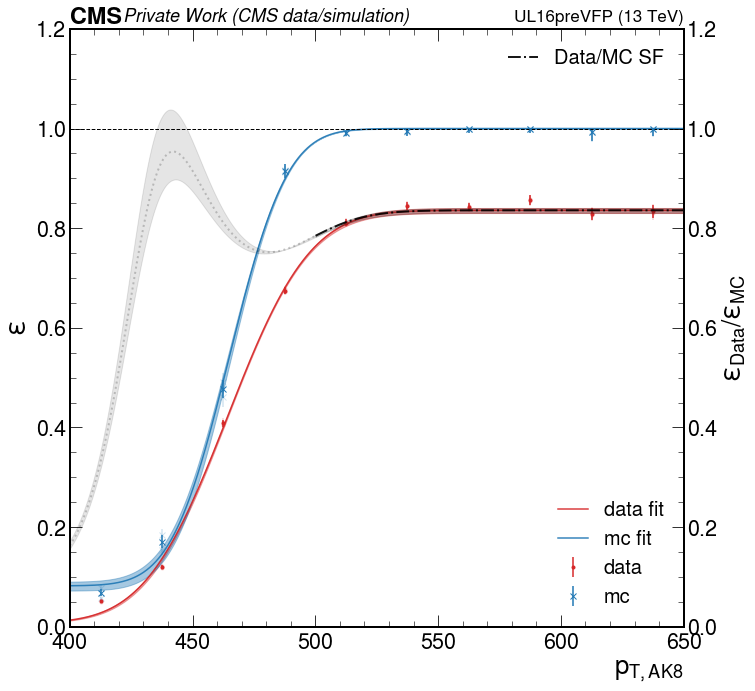

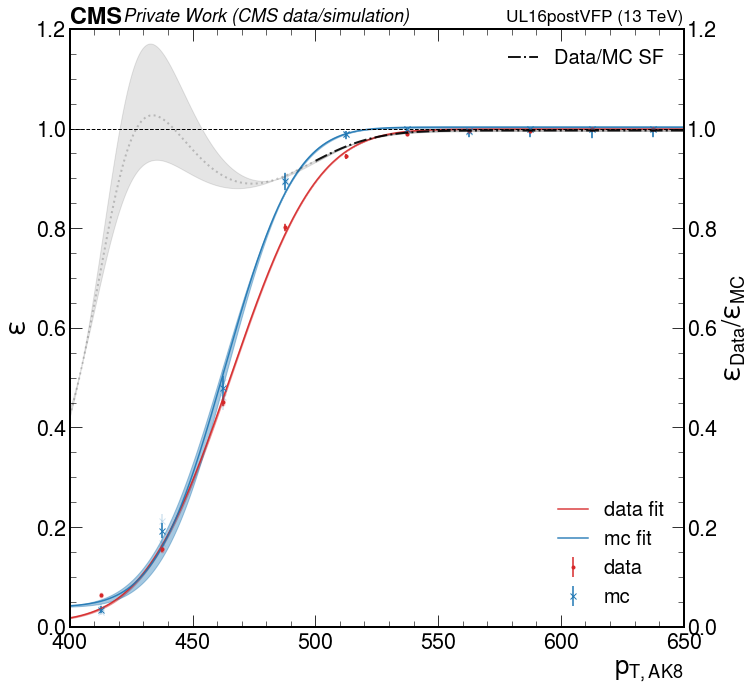

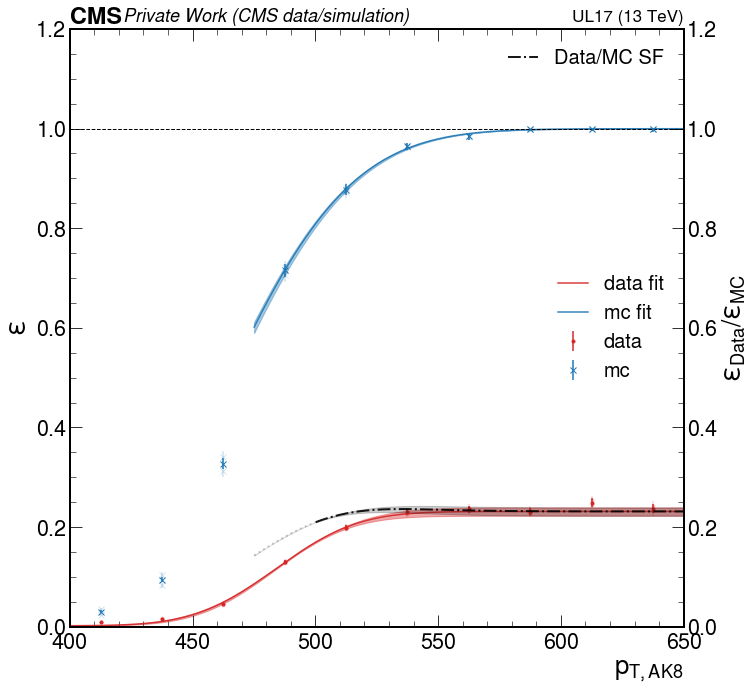

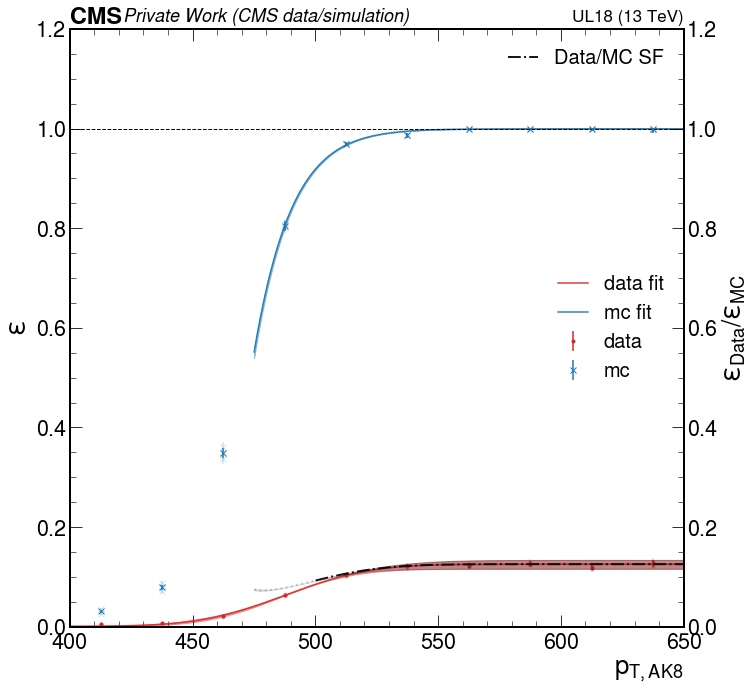

In [23]:
results = {}
results["UL16preVFP"] = plot_scalefactor("UL16preVFP",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet450",xmin=400, xmax=650,fitrange_mc=(400,575))
results["UL16postVFP"] = plot_scalefactor("UL16postVFP",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet450",xmin=400, xmax=650,fitrange_mc=(400,575))
results["UL17"] =plot_scalefactor("UL17",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet450",xmin=400, xmax=650,fitrange_mc=(475,1000),fitrange_data=(0,900))
results["UL18"] =plot_scalefactor("UL18",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet450",xmin=400, xmax=650,fitrange_mc=(475,900))


In [31]:
turn_on_erf = "{a:.10f}*({b:.10f}+0.5*(1-{b:.10f})*(1+erf((x-{c:.10f})/{d:.10f})))"

corrs = [
    cs.Correction(
        name=f"HLT_AK8PFJet450_triggersf_{year}",
        description=f"pT-dependent trigger MC to Data scalefactor for {year} MC",
        version=1,
        inputs=[
            cs.Variable(name="pt", type="real", description="Transverse momentum of AK8-jet."),
            cs.Variable(name="var", type="string", description="Apply nominal SF or up/down var."),
        ],
        output=cs.Variable(name="weight",type="real"),
        data=cs.Category(
            nodetype="category",
            input="var",
            content=[
                cs.CategoryItem(
                    key=var,
                    value=cs.Formula(
                        nodetype="formula",
                        variables=["pt"],
                        parser="TFormula",
                        expression=turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"][var]["data"])))
                        + "/"
                        + turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"][var]["mc"])))
                    )
                )
                for var in ["up", "down"]
            ],
            default=cs.Formula(
                        nodetype="formula",
                        variables=["pt"],
                        parser="TFormula",
                        expression=turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"]["nominal"]["data"])))
                        + "/"
                        + turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"]["nominal"]["mc"])))

            )
        )
    )
    for year in ["UL16preVFP", "UL16postVFP", "UL17", "UL18"]
]


IndexError: map::at:  key not found

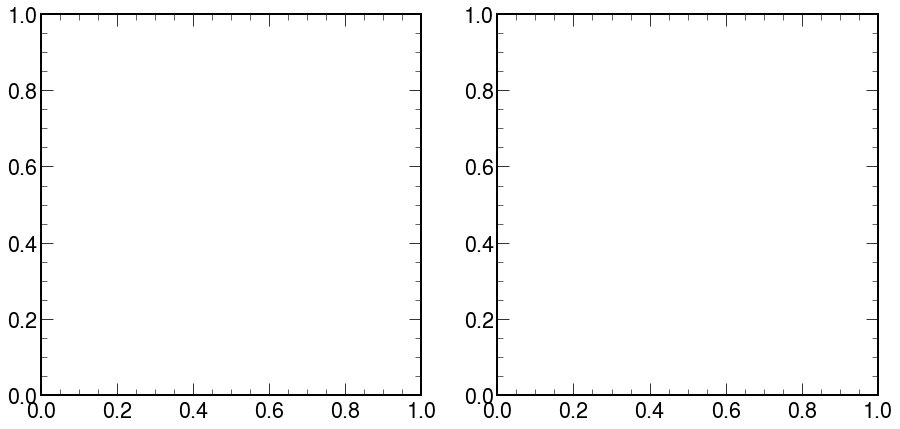

# AK8PFJet500
repeat for AK8PFJet500 to make sure we actually are in plateau starting with second $p_T$ bin ($p_T >650~$GeV)

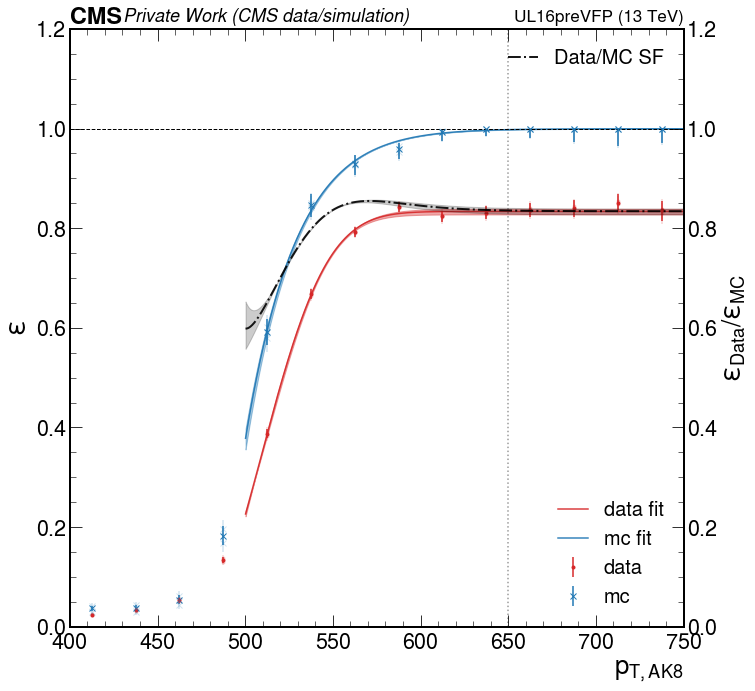

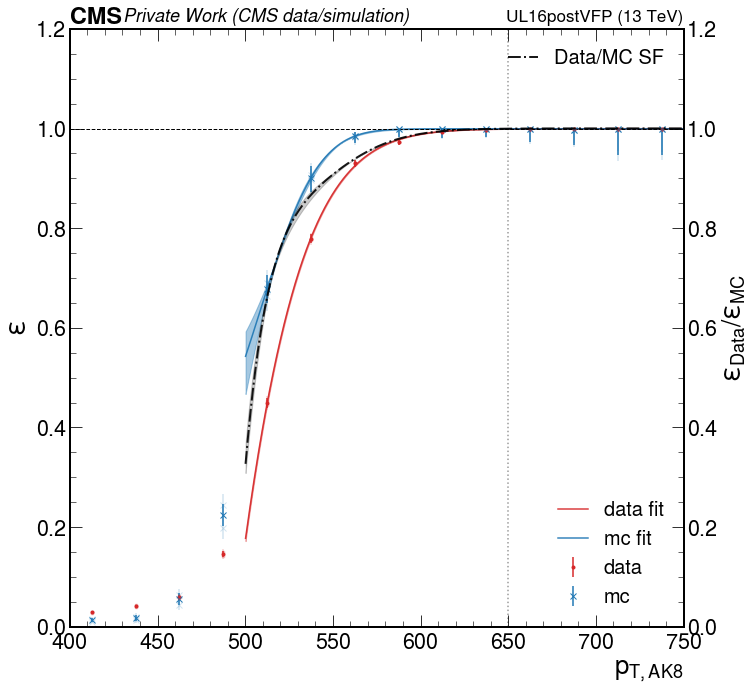

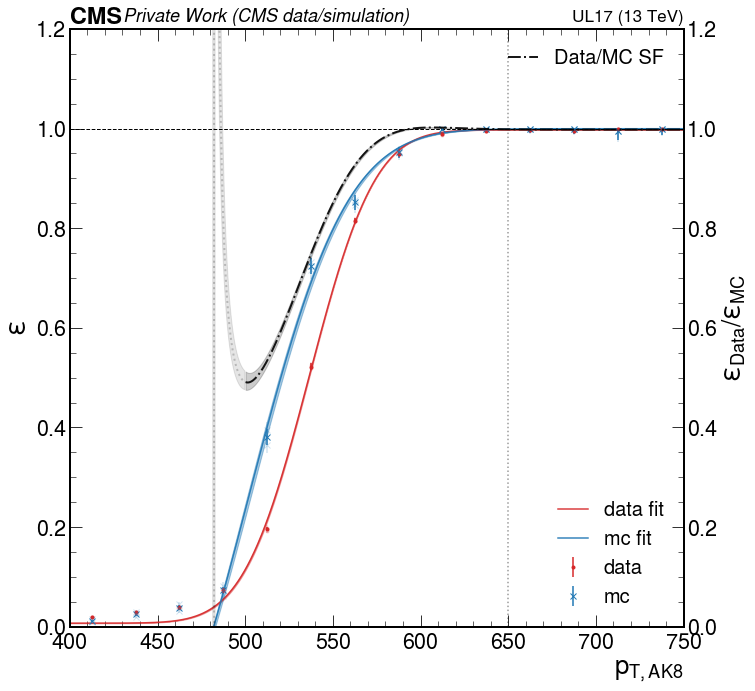

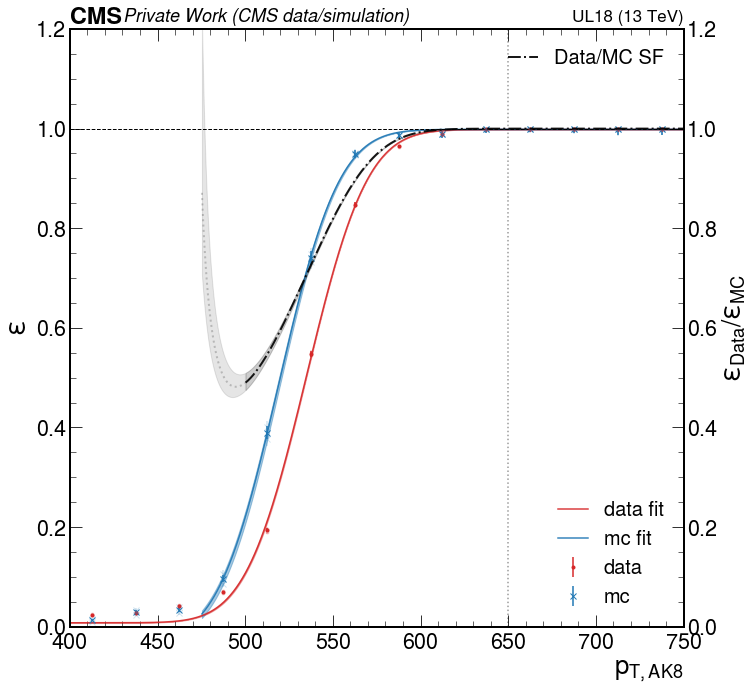

In [27]:
results = {}
results["UL16preVFP"] = plot_scalefactor("UL16preVFP",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet500",xmin=400, xmax=750,fitrange_mc=(500,1000), fitrange_data=(500,1000))
results["UL16postVFP"] = plot_scalefactor("UL16postVFP",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet500",xmin=400, xmax=750,fitrange_mc=(500,1000), fitrange_data=(500,1000))
results["UL17"] =plot_scalefactor("UL17",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet500",xmin=400, xmax=750,fitrange_mc=(475,1000),fitrange_data=(0,900))
results["UL18"] =plot_scalefactor("UL18",ref_trig = "IsoMuonReference",probe_trig="AK8PFJet500",xmin=400, xmax=750,fitrange_mc=(475,900))


In [34]:
turn_on_erf = "{a:.10f}*({b:.10f}+0.5*(1-{b:.10f})*(1+erf((x-{c:.10f})/{d:.10f})))"

corrs += [
    cs.Correction(
        name=f"HLT_AK8PFJet500_triggersf_{year}",
        description=f"pT-dependent trigger MC to Data scalefactor for {year} MC",
        version=1,
        inputs=[
            cs.Variable(name="pt", type="real", description="Transverse momentum of AK8-jet."),
            cs.Variable(name="var", type="string", description="Apply nominal SF or up/down var."),
        ],
        output=cs.Variable(name="weight",type="real"),
        data=cs.Category(
            nodetype="category",
            input="var",
            content=[
                cs.CategoryItem(
                    key=var,
                    value=cs.Formula(
                        nodetype="formula",
                        variables=["pt"],
                        parser="TFormula",
                        expression=turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"][var]["data"])))
                        + "/"
                        + turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"][var]["mc"])))
                    )
                )
                for var in ["up", "down"]
            ],
            default=cs.Formula(
                        nodetype="formula",
                        variables=["pt"],
                        parser="TFormula",
                        expression=turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"]["nominal"]["data"])))
                        + "/"
                        + turn_on_erf.format(**dict(zip(["a","b","c","d"],results[year]["parameter"]["nominal"]["mc"])))

            )
        )
    )
    for year in ["UL16preVFP", "UL16postVFP", "UL17", "UL18"]
]

correction_set = cs.CorrectionSet(
    schema_version=2,
    description=(
        "pT-reco dependent trigger sf for HLT_AK8PFJet500_v*,"
        "with IsoMu27 + offline selection as reference,"
        "measured in SingleMuon PD"
    ),
    corrections=corrs,
)
rich.print(correction_set)

CorrectionSet (schema v2)
pT-reco dependent trigger sf for HLT_AK8PFJet500_v*,with IsoMu27 + offline selection as 
reference,measured in SingleMuon PD
📂
├── 📈 HLT_AK8PFJet450_triggersf_UL16preVFP (v1)
│   pT-dependent trigger MC to Data scalefactor for UL16preVFP MC
│   Node counts: Category: 1, Formula: 3
│   ╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ─────────────╮
│   │ pt (real)                       │ │ var (string)                     │
│   │ Transverse momentum of AK8-jet. │ │ Apply nominal SF or up/down var. │
│   │ Range: [-inf, inf), overflow ok │ │ Values: down, up                 │
│   ╰─────────────────────────────────╯ │ has default                      │
│                                       ╰──────────────────────────────────╯
│   ╭─── ◀ output ───╮
│   │ weight (real)  │
│   │ No description │
│   ╰────────────────╯
├── 📈 HLT_AK8PFJet450_triggersf_UL16postVFP (v1)
│   pT-dependent trigger MC to Data scalefactor for UL16postVFP MC
│   Node counts: Category: 1, Formula: 3
│   ╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ─────────────╮
│   │ pt (real)                       │ │ var (string)                     │
│   │ Transverse momentum of AK8-jet. │ │ Apply nominal SF or up/down var. │
│   │ Range: [-inf, inf), overflow ok │ │ Values: down, up                 │
│   ╰─────────────────────────────────╯ │ has default                      │
│                                       ╰──────────────────────────────────╯
│   ╭─── ◀ output ───╮
│   │ weight (real)  │
│   │ No description │
│   ╰────────────────╯
├── 📈 HLT_AK8PFJet450_triggersf_UL17 (v1)
│   pT-dependent trigger MC to Data scalefactor for UL17 MC
│   Node counts: Category: 1, Formula: 3
│   ╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ─────────────╮
│   │ pt (real)                       │ │ var (string)                     │
│   │ Transverse momentum of AK8-jet. │ │ Apply nominal SF or up/down var. │
│   │ Range: [-inf, inf), overflow ok │ │ Values: down, up                 │
│   ╰─────────────────────────────────╯ │ has default                      │
│                                       ╰──────────────────────────────────╯
│   ╭─── ◀ output ───╮
│   │ weight (real)  │
│   │ No description │
│   ╰────────────────╯
├── 📈 HLT_AK8PFJet450_triggersf_UL18 (v1)
│   pT-dependent trigger MC to Data scalefactor for UL18 MC
│   Node counts: Category: 1, Formula: 3
│   ╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ─────────────╮
│   │ pt (real)                       │ │ var (string)                     │
│   │ Transverse momentum of AK8-jet. │ │ Apply nominal SF or up/down var. │
│   │ Range: [-inf, inf), overflow ok │ │ Values: down, up                 │
│   ╰─────────────────────────────────╯ │ has default                      │
│                                       ╰──────────────────────────────────╯
│   ╭─── ◀ output ───╮
│   │ weight (real)  │
│   │ No description │
│   ╰────────────────╯
├── 📈 HLT_AK8PFJet500_triggersf_UL16preVFP (v1)
│   pT-dependent trigger MC to Data scalefactor for UL16preVFP MC
│   Node counts: Category: 1, Formula: 3
│   ╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ─────────────╮
│   │ pt (real)                       │ │ var (string)                     │
│   │ Transverse momentum of AK8-jet. │ │ Apply nominal SF or up/down var. │
│   │ Range: [-inf, inf), overflow ok │ │ Values: down, up                 │
│   ╰─────────────────────────────────╯ │ has default                      │
│                                       ╰──────────────────────────────────╯
│   ╭─── ◀ output ───╮
│   │ weight (real)  │
│   │ No description │
│   ╰────────────────╯
├── 📈 HLT_AK8PFJet500_triggersf_UL16postVFP (v1)
│   pT-dependent trigger MC to Data scalefactor for UL16postVFP MC
│   Node counts: Category: 1, Formula: 3
│   ╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ─────────────╮
│   │ pt (real)                       │ │ var (string)                     │
│   │ Transve

In [35]:
corrections_set_json = correction_set.json(exclude_unset=True)
sha512sum = sha512(corrections_set_json.encode("utf-8")).hexdigest()
fname = f"data/HLT_AK8PFJet_MC_trigger_sf_{sha512sum[-10:]}.json"
with open(fname, "w") as fout:
    fout.write(corrections_set_json)


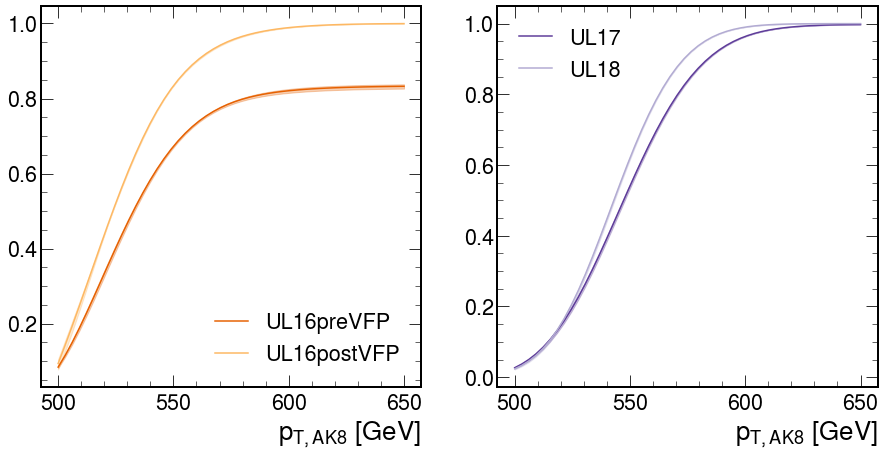

In [36]:
import correctionlib as cl
cset = cl.CorrectionSet.from_file(fname)

colors = [
    '#e66101',
    '#fdb863',
    '#5e3c99',
    '#b2abd2',
    '#a6cee3',
    '#1f78b4',
    '#b2df8a',
    '#33a02c',
]
pt = np.linspace(500,650)

f,(ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
icolor=0
for year in ["UL16preVFP", "UL16postVFP"]:
    ax1.plot(pt,cset[f"HLT_AK8PFJet450_triggersf_{year}"].evaluate(pt,"nominal"), color=colors[icolor], label=year)
    ax1.fill_between(pt, cset[f"HLT_AK8PFJet450_triggersf_{year}"].evaluate(pt,"down"),cset[f"HLT_AK8PFJet450_triggersf_{year}"].evaluate(pt,"up"), color=colors[icolor],alpha=0.3)
    icolor+=1
# in UL17 and UL18 PFJet450 is prescaled
# f,ax = plt.subplots()
for year in ["UL17", "UL18"]:
    ax2.plot(pt,cset[f"HLT_AK8PFJet450_triggersf_{year}"].evaluate(pt,"nominal"), color=colors[icolor], label=year)
    ax2.fill_between(pt, cset[f"HLT_AK8PFJet450_triggersf_{year}"].evaluate(pt,"down"),cset[f"HLT_AK8PFJet450_triggersf_{year}"].evaluate(pt,"up"), color=colors[icolor],alpha=0.3)
    icolor+=1
for ax in [ax1,ax2]:
    ax.legend()
    ax.set_xlabel("$p_{T,AK8}~$[GeV]")

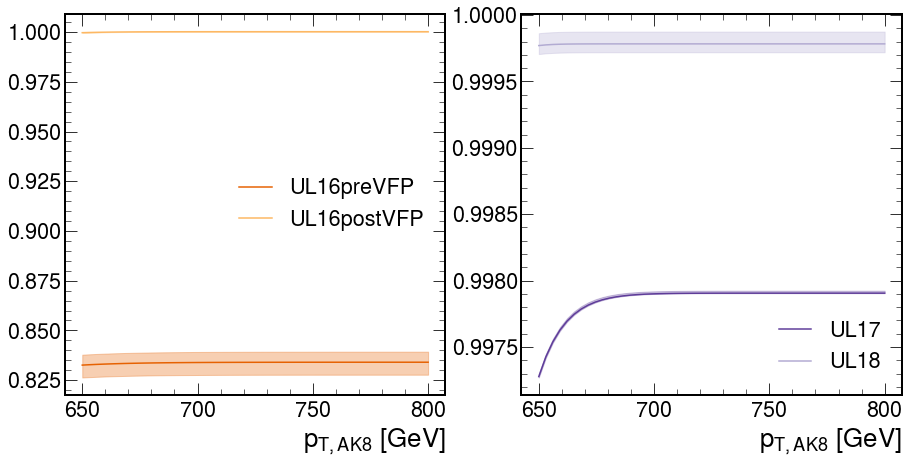

In [37]:

colors = [
    '#e66101',
    '#fdb863',
    '#5e3c99',
    '#b2abd2',
    '#a6cee3',
    '#1f78b4',
    '#b2df8a',
    '#33a02c',
]
pt = np.linspace(650,800)

f,(ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
icolor=0
for year in ["UL16preVFP", "UL16postVFP"]:
    ax1.plot(pt,cset[f"HLT_AK8PFJet500_triggersf_{year}"].evaluate(pt,"nominal"), color=colors[icolor], label=year)
    ax1.fill_between(pt, cset[f"HLT_AK8PFJet500_triggersf_{year}"].evaluate(pt,"down"),cset[f"HLT_AK8PFJet500_triggersf_{year}"].evaluate(pt,"up"), color=colors[icolor],alpha=0.3)
    icolor+=1
# in UL17 and UL18 PFJet450 is prescaled
# f,ax = plt.subplots()
for year in ["UL17", "UL18"]:
    ax2.plot(pt,cset[f"HLT_AK8PFJet500_triggersf_{year}"].evaluate(pt,"nominal"), color=colors[icolor], label=year)
    ax2.fill_between(pt, cset[f"HLT_AK8PFJet500_triggersf_{year}"].evaluate(pt,"down"),cset[f"HLT_AK8PFJet500_triggersf_{year}"].evaluate(pt,"up"), color=colors[icolor],alpha=0.3)
    icolor+=1
for ax in [ax1,ax2]:
    ax.legend()
    ax.set_xlabel("$p_{T,AK8}~$[GeV]")